In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()

Saving Brooklyn_Bridge_Automated_Pedestrian_Counts_Demonstration_Project_20251022.csv to Brooklyn_Bridge_Automated_Pedestrian_Counts_Demonstration_Project_20251022.csv


In [2]:
fname = next(iter(uploaded))
df = pd.read_csv(fname)

In [5]:
# Read and standardize
df = pd.read_csv(fname)
df["dt"] = pd.to_datetime(df["hour_beginning"], errors="coerce")
df = df[df["dt"].notna()].copy()

/tmp/ipython-input-1536086501.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["dt"] = pd.to_datetime(df["hour_beginning"], errors="coerce")


In [6]:
# Derived columns
df["weekday"] = df["dt"].dt.day_name()
df["year"]    = df["dt"].dt.year
df["hour"]    = df["dt"].dt.hour

In [7]:
# key fields from this csv
COUNT_COL   = "Pedestrians"
WX_SUMMARY  = "weather_summary"

In [8]:
# make sure counts are numeric
df[COUNT_COL] = pd.to_numeric(df[COUNT_COL], errors="coerce")

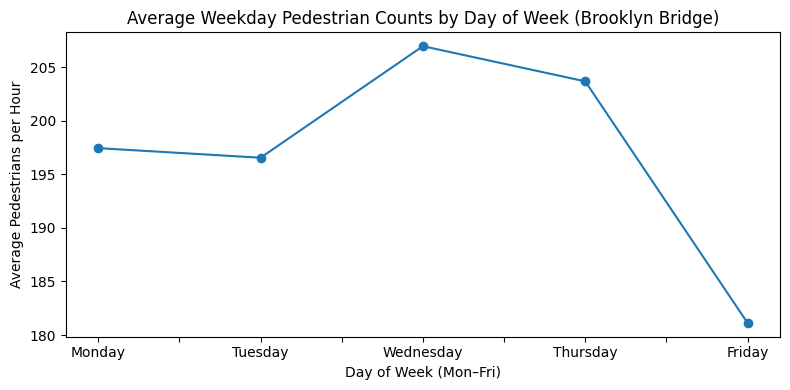

In [9]:
# ========= task 1: weekdays line plot =========
weekday_df = df[df["dt"].dt.weekday < 5].copy()
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday"]

day_avg = (weekday_df
           .groupby("weekday", as_index=False)[COUNT_COL]
           .mean()
           .set_index("weekday")
           .reindex(weekday_order))

plt.figure(figsize=(8,4))
day_avg[COUNT_COL].plot(kind="line", marker="o")
plt.title("Average Weekday Pedestrian Counts by Day of Week (Brooklyn Bridge)")
plt.xlabel("Day of Week (Mon–Fri)")
plt.ylabel("Average Pedestrians per Hour")
plt.tight_layout()
plt.show()

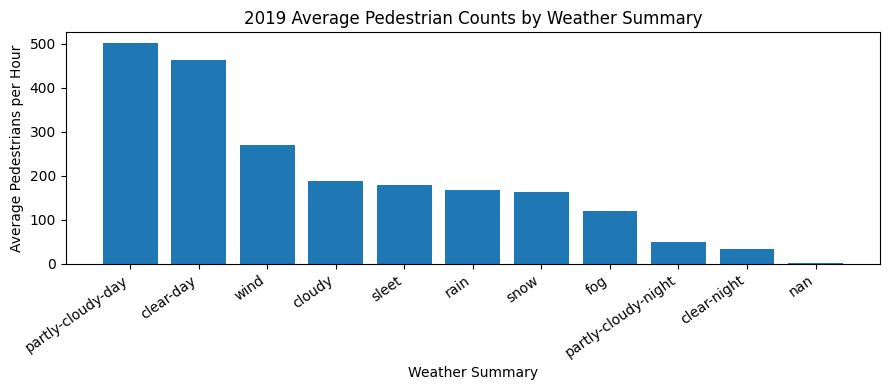

In [10]:
# ========= task 2: 2019 weather impact =========
# focus on 2019
df2019 = df[df["year"] == 2019].copy()

by_weather = (df2019
              .groupby(WX_SUMMARY, dropna=False)[COUNT_COL]
              .mean()
              .sort_values(ascending=False)
              .to_frame("avg_count")
              .reset_index())

plt.figure(figsize=(9,4))
plt.bar(by_weather[WX_SUMMARY].astype(str), by_weather["avg_count"])
plt.xticks(rotation=35, ha="right")
plt.title("2019 Average Pedestrian Counts by Weather Summary")
plt.xlabel("Weather Summary")
plt.ylabel("Average Pedestrians per Hour")
plt.tight_layout()
plt.show()

In [11]:
# build correlation matrix
# use temperature, precipitation, and one-hot weather labels
numeric_weather_cols = [c for c in ["temperature","precipitation"] if c in df2019.columns]
for c in numeric_weather_cols:
    df2019[c] = pd.to_numeric(df2019[c], errors="coerce")

pieces = [df2019[[COUNT_COL] + numeric_weather_cols].reset_index(drop=True)]
wx_dummies = pd.get_dummies(df2019[WX_SUMMARY].astype("category"),
                            prefix="wx", dummy_na=True).reset_index(drop=True)
pieces.append(wx_dummies)

corr_input = pd.concat(pieces, axis=1)
corr = corr_input.corr(numeric_only=True)
print("Correlation Matrix (2019):")
print(corr.round(3))

Correlation Matrix (2019):
                        Pedestrians  temperature  precipitation  wx_clear-day  \
Pedestrians                   1.000        0.063         -0.022         0.367   
temperature                   0.063        1.000          0.002         0.013   
precipitation                -0.022        0.002          1.000        -0.083   
wx_clear-day                  0.367        0.013         -0.083         1.000   
wx_clear-night               -0.332       -0.215         -0.099        -0.228   
wx_cloudy                     0.056       -0.084         -0.069        -0.224   
wx_fog                       -0.009       -0.027          0.001        -0.022   
wx_partly-cloudy-day          0.401        0.314         -0.093        -0.221   
wx_partly-cloudy-night       -0.216        0.009         -0.072        -0.175   
wx_rain                       0.010       -0.017          0.616        -0.120   
wx_sleet                      0.002       -0.035          0.031        -0.013   
w

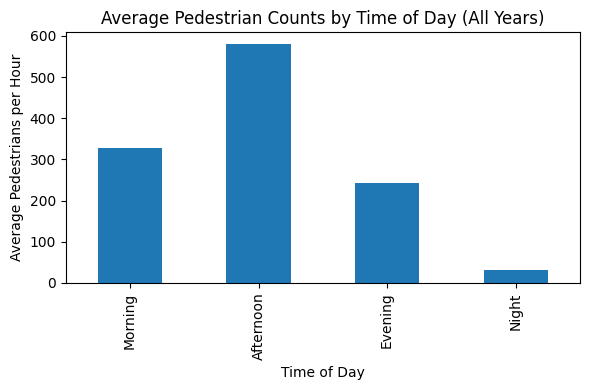

In [12]:
# ========= task 3: time-of-day buckets =========
# my buckets: morning 6–11, afternoon 12–17, evening 18–21, night 22–5
def time_of_day_bucket(h):
    # Morning 6–11, Afternoon 12–17, Evening 18–21, Night 22–5
    if 6 <= h <= 11:
        return "Morning"
    if 12 <= h <= 17:
        return "Afternoon"
    if 18 <= h <= 21:
        return "Evening"
    return "Night"

df["time_of_day"] = df["hour"].apply(time_of_day_bucket)

# 全时期按时段的平均人流量
tod_avg = (df.groupby("time_of_day")[COUNT_COL]
             .mean()
             .reindex(["Morning","Afternoon","Evening","Night"]))

plt.figure(figsize=(6,4))
tod_avg.plot(kind="bar")
plt.title("Average Pedestrian Counts by Time of Day (All Years)")
plt.xlabel("Time of Day")
plt.ylabel("Average Pedestrians per Hour")
plt.tight_layout()
plt.show()


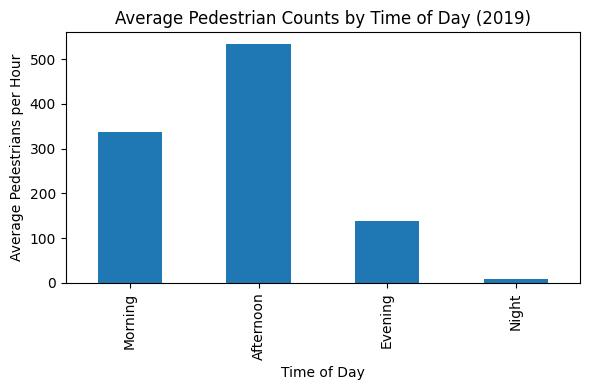

In [13]:
# 2019 only (nice to compare)
df2019["time_of_day"] = df2019["hour"].apply(time_of_day_bucket)
tod_avg_2019 = (df2019.groupby("time_of_day")[COUNT_COL]
                  .mean()
                  .reindex(["Morning","Afternoon","Evening","Night"]))

plt.figure(figsize=(6,4))
tod_avg_2019.plot(kind="bar")
plt.title("Average Pedestrian Counts by Time of Day (2019)")
plt.xlabel("Time of Day")
plt.ylabel("Average Pedestrians per Hour")
plt.tight_layout()
plt.show()